Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Mejora de las graficas de la version 6

In [1]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [2]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [4]:
#Datos de entrenamiento 80%
ShanghaiDat_train=ShanghaiDat.iloc[:, 0:3900]
#Datos de prueba 20%
ShanghaiDat_test=ShanghaiDat.iloc[:, 3900:]


In [5]:
ShanghaiDat_train2 = ShanghaiDat_train

In [6]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

#Convertimos los datos a un array de 1 dimension (tomamos los datos de entrenamiento)
ShanghaiDat_train = np.array(ShanghaiDat_train).flatten()


#Aplicamos MinMaxScaler a los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ShanghaiDat_train = scaler.fit_transform(ShanghaiDat_train.reshape(-1, 1)).flatten()


#Dividimos en epocas de n dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat_train)
    sequences = [ShanghaiDat_train[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat_train[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)


In [7]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences 
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [8]:
#Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512, d_model=4):
        super(TransformerModel, self).__init__()
        self.sequence_length = sequence_length
        self.embedding = nn.Linear(input_size, d_model)  # Proyección a d_model
        
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model * sequence_length, 1)

    def forward(self, src):
        src = src.reshape(-1, self.sequence_length, 1)  # (batch_size, seq_len, input_size)
        src = self.embedding(src)  # (batch_size, seq_len, d_model)
        src = src.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        out = self.transformer_encoder(src)
        out = out.permute(1, 0, 2)  # (batch_size, seq_len, d_model)
        out = out.flatten(start_dim=1)  # (batch_size, seq_len * d_model)
        return self.fc_out(out)



In [9]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [10]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

#Training loop
losses=[]
for epoch in range(150):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.004458521492779255
Epoch 2, Loss: 0.00594744086265564
Epoch 3, Loss: 0.002221661387011409
Epoch 4, Loss: 0.0012516878778114915
Epoch 5, Loss: 0.00042053021024912596
Epoch 6, Loss: 0.0010539902141317725
Epoch 7, Loss: 0.0025321391876786947
Epoch 8, Loss: 0.0007359120645560324
Epoch 9, Loss: 0.0015763328410685062
Epoch 10, Loss: 0.0017043447587639093
Epoch 11, Loss: 0.0027665188536047935
Epoch 12, Loss: 0.0007286452455446124
Epoch 13, Loss: 0.001777909230440855
Epoch 14, Loss: 0.0013033184222877026
Epoch 15, Loss: 0.0011724099749699235
Epoch 16, Loss: 0.001644836738705635
Epoch 17, Loss: 0.00153608457185328
Epoch 18, Loss: 0.001215785858221352
Epoch 19, Loss: 0.0007795043056830764
Epoch 20, Loss: 0.0009334131027571857
Epoch 21, Loss: 0.0005889590829610825
Epoch 22, Loss: 0.0007590829045511782
Epoch 23, Loss: 0.0008969492046162486
Epoch 24, Loss: 0.0007613182533532381
Epoch 25, Loss: 0.0014790939167141914
Epoch 26, Loss: 0.0022349124774336815
Epoch 27, Loss: 0.00171910948

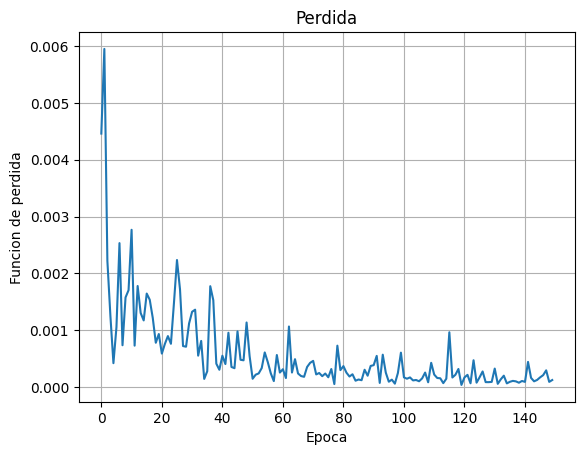

In [11]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.title('Perdida')
plt.xlabel('Epoca')
plt.grid()
plt.ylabel('Funcion de perdida')
plt.plot(losses)
plt.show()

In [12]:
# Veamos cómo predice el modelo

# Tomamos una secuencia ya escalada (por ejemplo, la primera del dataset)
test_seq = sequences[0].reshape(-1, 1)  # La convertimos a forma columna
test_seq = scaler.transform(test_seq).flatten()  # La reescalamos (aunque ya estaba escalada, es por claridad y generalidad)

# Convertimos a tensor y agregamos dimensión de batch
test_seq_tensor = torch.tensor(test_seq).float().unsqueeze(0).to(device)

# Obtenemos la predicción del modelo
with torch.no_grad():
    predicted_scaled = model(test_seq_tensor)

# Convertimos de vuelta a numpy
predicted_scaled_np = predicted_scaled.cpu().numpy()

# Desescalamos la predicción a su valor original
predicted_real = scaler.inverse_transform(predicted_scaled_np)

print("Predicción:", predicted_real.item())
print("Dato siguiente real:", scaler.inverse_transform([[next_points[0]]])[0][0])


Predicción: 727.2644653320312
Dato siguiente real: 1204.39404296875


In [13]:
#Comparemos los datos reales con las predicciones que hace el modelo
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = test_seq.unsqueeze(0)
    test_seq = test_seq.to(device)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())

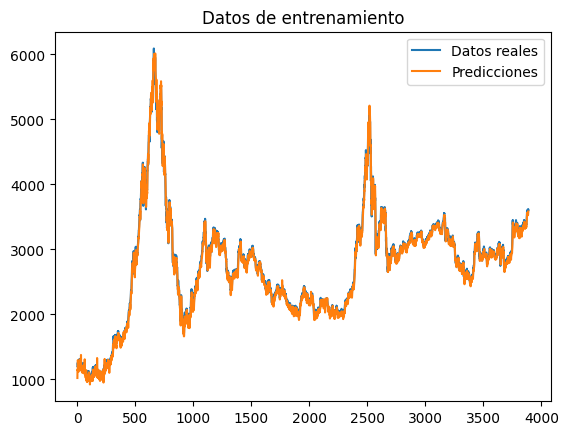

In [14]:
#Graficamos los datos desnormalizados
predicciones_array = np.array(predicciones).reshape(-1, 1)

predicciones_desnormalizadas = scaler.inverse_transform(predicciones_array)
ShanghaiDat_desnormalizado = scaler.inverse_transform(ShanghaiDat_train.reshape(-1, 1))

ShanghaiDat_desnormalizado = ShanghaiDat_desnormalizado[12:] #Ignoramos los primeros 12 datos reales, pues la primera prediccion corresponde al dato real numero 13

plt.plot(ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(predicciones_desnormalizadas, label='Predicciones')
plt.title('Datos de entrenamiento')
plt.legend()
plt.show()

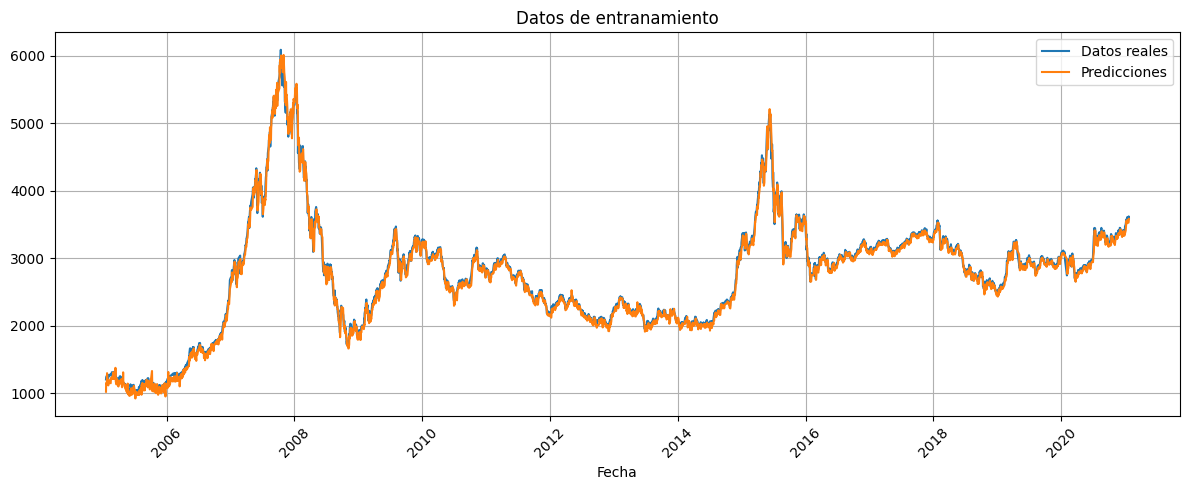

In [15]:
#Graficamos con fechas
lista_fechas=ShanghaiDat_train2.columns
fechas = pd.to_datetime(lista_fechas[12:])  # Para alinear con tus datos desde el índice 12

plt.figure(figsize=(12, 5))  # más espacio para el eje x

plt.plot(fechas, ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(fechas, predicciones_desnormalizadas, label='Predicciones')

plt.title('Datos de entranamiento')
plt.xlabel('Fecha')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # rotar para evitar que se encimen
plt.tight_layout()  # ajusta márgenes automáticamente
plt.show()

In [16]:
'''Ahora con los datos de prueba (20% = 975)'''
valores_reales = np.array(ShanghaiDat_test).flatten()

#Aplicamos MinMaxScaler a los datos
valores_reales = scaler.fit_transform(valores_reales.reshape(-1, 1)).flatten()

#Dividimos los datos en ventanas deslizantes
def Epocas2(sequence_length=12):
    size = len(valores_reales) 
    sequences = [valores_reales[i:i+sequence_length] for i in range(size-sequence_length)]

    return np.array(sequences)

sequences = Epocas2()


#Calculamos las predicciones con el modelo ya entrenado
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = test_seq.unsqueeze(0)
    test_seq = test_seq.to(device)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicciones.append(predicted_point.item())

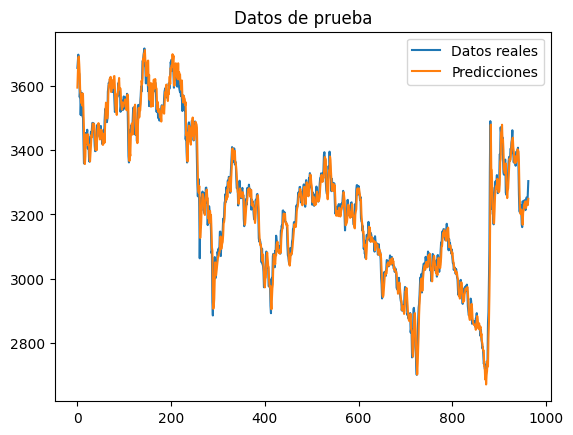

In [17]:
#Graficamos los datos desnormalizados
predicciones_array = np.array(predicciones).reshape(-1, 1)

predicciones_desnormalizadas = scaler.inverse_transform(predicciones_array)
ShanghaiDat_desnormalizado = scaler.inverse_transform(valores_reales.reshape(-1, 1))

ShanghaiDat_desnormalizado = ShanghaiDat_desnormalizado[12:] #Ignoramos los primeros 12 datos reales, pues la primera prediccion corresponde al dato real numero 13

plt.plot(ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(predicciones_desnormalizadas, label='Predicciones')
plt.title('Datos de prueba')
plt.legend()
plt.show()

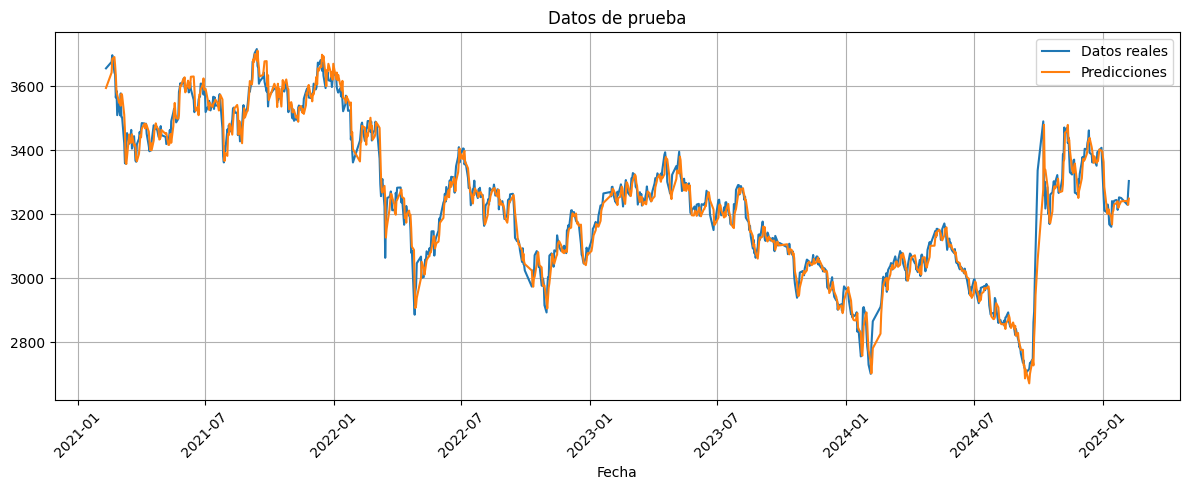

In [18]:
#Graficamos con fechas
lista_fechas=ShanghaiDat_test.columns
fechas = pd.to_datetime(lista_fechas[12:])  # Para alinear con tus datos desde el índice 12

plt.figure(figsize=(12, 5))  # más espacio para el eje x

plt.plot(fechas, ShanghaiDat_desnormalizado, label='Datos reales')
plt.plot(fechas, predicciones_desnormalizadas, label='Predicciones')

plt.title('Datos de prueba')
plt.xlabel('Fecha')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # rotar para evitar que se encimen
plt.tight_layout()  # ajusta márgenes automáticamente
plt.show()

In [19]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-1.0495],
                      [-0.0244],
                      [-0.5445],
                      [-0.3118]], device='cuda:0')),
             ('embedding.bias',
              tensor([ 0.8802,  0.3802,  0.0948, -0.1601], device='cuda:0')),
             ('encoder_layer.self_attn.in_proj_weight',
              tensor([[-0.5798,  0.2026,  0.2090,  0.1501],
                      [-0.0864,  0.2061,  0.4094,  0.6009],
                      [ 0.1009, -0.4079, -0.5053,  0.4470],
                      [ 0.0923,  0.3361,  0.1548, -0.1553],
                      [ 0.2119, -0.3642, -0.2597, -0.5043],
                      [-0.1519,  0.2804, -0.1866, -0.3463],
                      [ 0.0356, -0.3969,  0.0701,  0.3043],
                      [-0.4418,  0.5198,  0.2858, -0.5778],
                      [ 0.1840,  0.3906, -0.5390,  0.1456],
                      [ 0.4124, -0.2675,  0.2040, -0.5312],
                      [-0.1792,  0.2621,  0.4931

In [20]:
'''embedding.weight y embedding.bias corresponden a la capa lineal que toma tu entrada de tamaño input_size=1 y la 
proyecta a d_model=4. Convierte cada serie de valores escalares en vectores de dimensión 4 para que el Transformer pueda procesarlos.

embedding.weight: forma (4, 1) → 4 neuronas (d_model) × 1 entrada.
embedding.bias: forma (4,) → un bias por cada neurona.'''


'''encoder_layer.self_attn.in_proj_weight son los pesos del mecanismo de atención multi-cabeza 
(Multi-Head Self-Attention). La capa de atención guarda Q, K y V en una sola matriz llamada in_proj_weight. Calcula las transformaciones 
lineales necesarias para obtener las consultas, claves y valores que usa la atención.

Forma (3 * d_model, d_model) → (12, 4) ya que

Q: (4,4)
K: (4,4)
V: (4,4)

encoder_layer.self_attn.in_proj_bias: (12,), un bias por cada valor de Q, K y V.'''





'encoder_layer.self_attn.in_proj_weight son los pesos del mecanismo de atención multi-cabeza \n(Multi-Head Self-Attention). La capa de atención guarda Q, K y V en una sola matriz llamada in_proj_weight. Calcula las transformaciones \nlineales necesarias para obtener las consultas, claves y valores que usa la atención.\n\nForma (3 * d_model, d_model) → (12, 4) ya que\n\nQ: (4,4)\nK: (4,4)\nV: (4,4)\n\nencoder_layer.self_attn.in_proj_bias: (12,), un bias por cada valor de Q, K y V.'